In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from dlem import util
from dlem import load_model
import seaborn

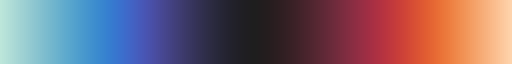

In [2]:
seaborn.color_palette("icefire", as_cmap=True)

In [3]:
dev = torch.device('cuda')

In [4]:
#patch = np.log(np.load("data/patch.npy"))
#patch = util.tile_patch(patch, kernel_size=10)
#patch = util.diagonal_normalize(patch[np.newaxis])[0]

In [5]:
#patch = np.load("../../../loopextrusion_data_creation/.data/thesis_vis/patch.npy")#[140:, 140:]
patch = np.load("data/patch_deep.npy")#[140:, 140:]

In [6]:
np.where(np.isnan(patch[0]))

(array([  0,   1,   2,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119]),)

In [7]:
patch[np.isnan(patch)] = 0

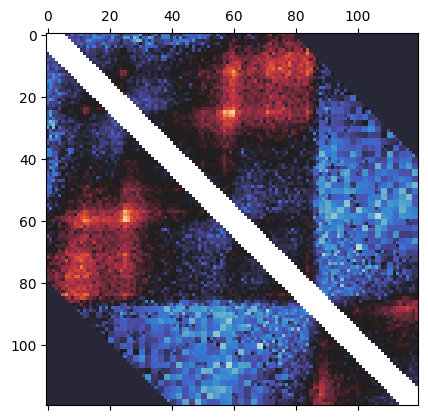

In [8]:
plt.matshow(util.ignore_diag_plot(patch, 5), cmap='icefire')

In [9]:
architecture = load_model("netdlem2")
#architecture = load_model("dlem_w_stalling")
model = architecture(np.ones(patch.shape[0]) * 0.95, np.ones(patch.shape[0]) * 0.95)#, free_unload=True)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.5)

In [11]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=25, mode="max")

In [12]:
diag_stop = int(np.floor(patch.shape[0]*0.3)) #we don't get much information from the corner anyway

In [13]:
diag_start = 3
diag_stop = 80

In [14]:
def weighted_mse_loss(input, target, weight=None):
    if weight is None:
        weight = torch.exp(target)
    return torch.mean(weight * (input - target) ** 2)
loss = torch.nn.MSELoss(reduction='mean')
#loss = weighted_mse_loss

In [15]:
best_loss_model, best_corr_model, arr_loss, arr_corr = util.train(model,
                                                                  optimizer,
                                                                  scheduler,
                                                                  loss,
                                                                  np.exp(patch)[np.newaxis],
                                                                  diag_start, diag_stop, dev, num_epoch=100)

Text(0, 0.5, 'correlation')

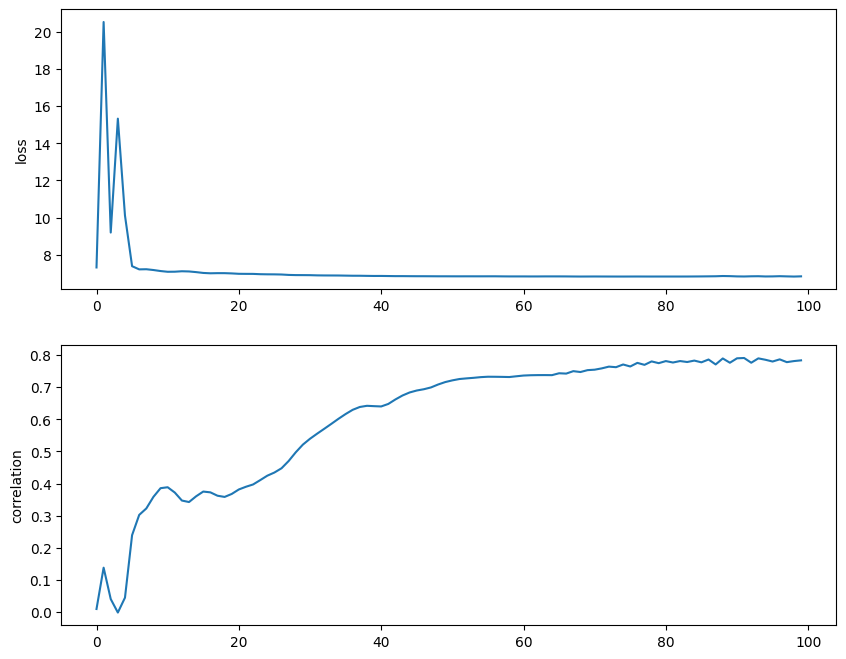

In [16]:
fig, axes = plt.subplots(nrows=2, figsize=(10,8))
axes[0].plot(arr_loss)
axes[0].set_ylabel("loss")
axes[1].plot(arr_corr)
axes[1].set_ylabel("correlation")

In [17]:
best_loss_pred = best_loss_model.contact_map_prediction(torch.ones((1, patch.shape[0]), device=dev) * patch.shape[0]).detach().cpu().numpy()
best_loss_pred = util.diagonal_normalize(np.log(best_loss_pred))
best_loss_pred = best_loss_pred[0]

In [18]:
best_corr_pred = best_corr_model.contact_map_prediction(torch.ones((1, patch.shape[0]), device=dev) * patch.shape[0]).detach().cpu().numpy()
best_corr_pred = util.diagonal_normalize(np.log(best_corr_pred))
best_corr_pred = best_corr_pred[0]

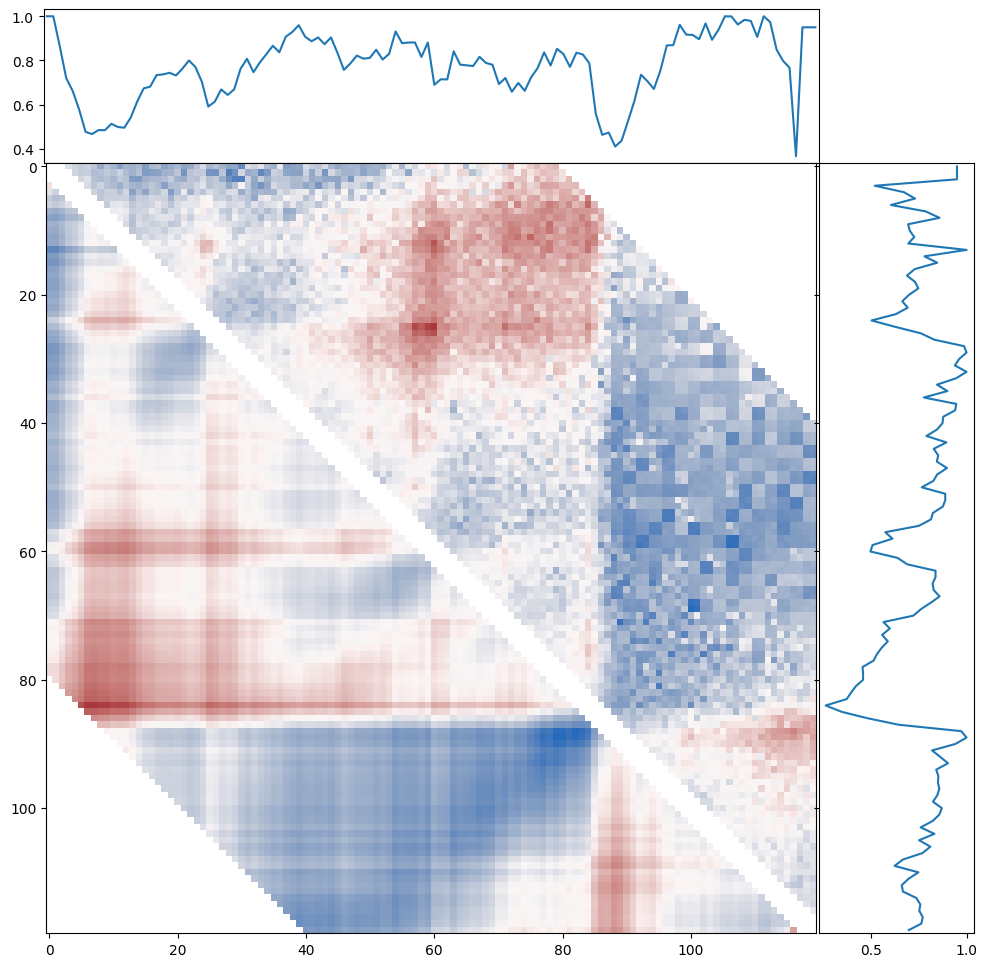

In [19]:
util.plot_results(patch, best_loss_pred, best_loss_model.return_parameters(), cmap="vlag", ignore_i_off=diag_stop, ignore_i=diag_start)

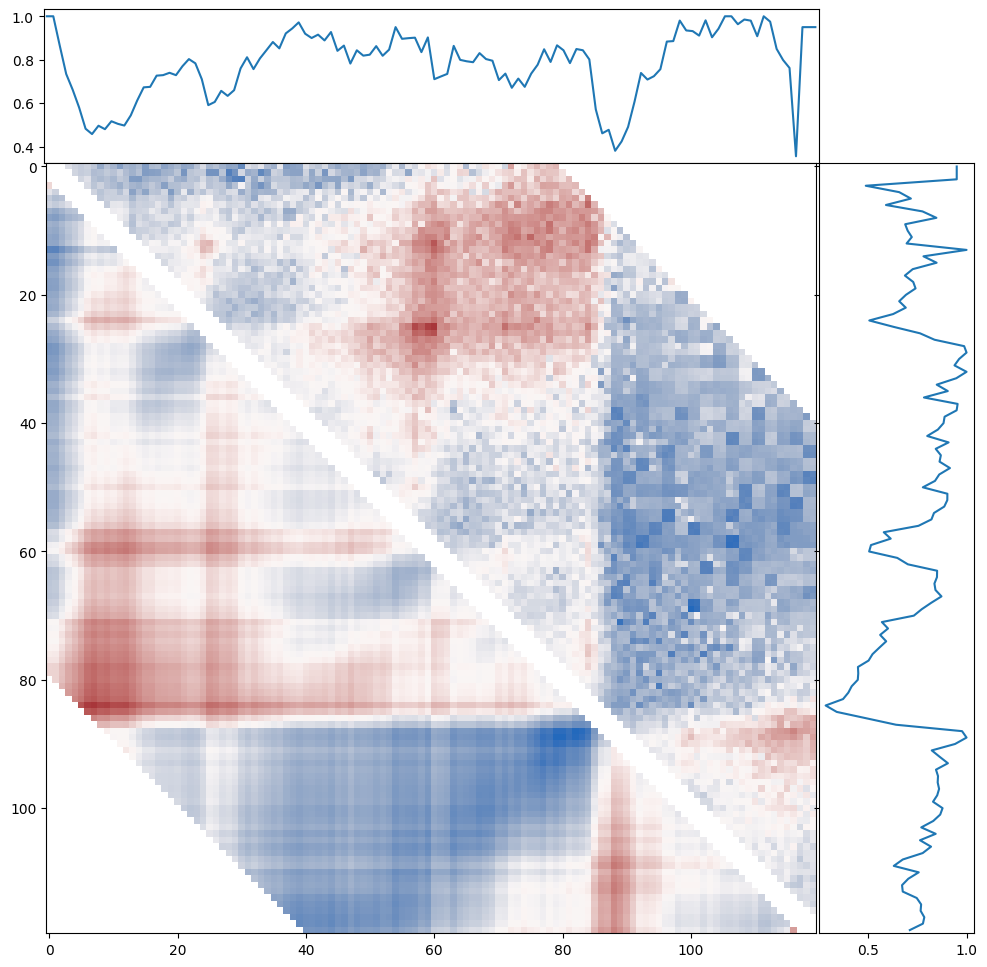

In [20]:
util.plot_results(patch, best_corr_pred, best_corr_model.return_parameters(), cmap="vlag", ignore_i_off=diag_stop, ignore_i=diag_start)

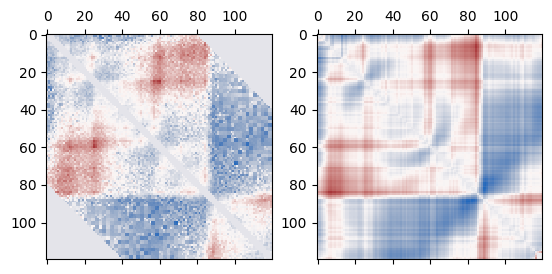

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].matshow(patch, cmap="vlag")
axes[1].matshow(best_corr_pred, cmap="vlag")

In [22]:
params = best_corr_model.return_parameters()

In [23]:
#np.save("../../../thesis_visual/fit.npy", best_corr_pred)
#np.save("../../../thesis_visual/left.npy", params[0])
#np.save("../../../thesis_visual/right.npy", params[1])


In [24]:
#tracks = np.load("../../../loopextrusion_data_creation/.data/thesis_vis/track.npy")
tracks = np.load("data/encode_deep.npy")

In [25]:
tracks.shape

(4, 120)

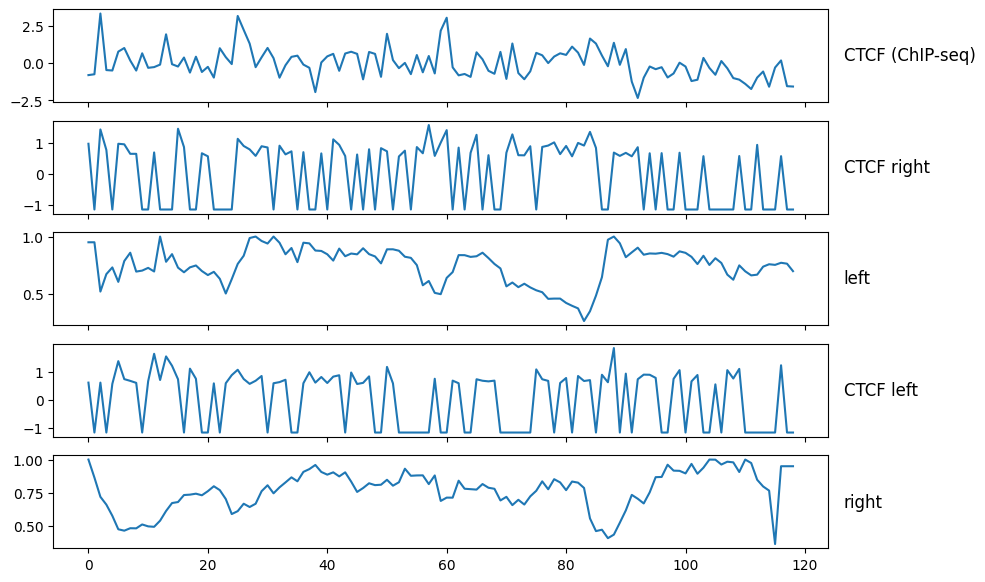

In [26]:
tick_labels = ["CTCF (ChIP-seq)", "CTCF right", "left", "CTCF left", "right"]
fig, axes = plt.subplots(nrows=5, sharex="col", figsize=(10,7))
axes[0].plot(tracks[0][:-1])
#axes[1].plot(tracks[1])
axes[1].plot(tracks[3][:-1])
axes[2].plot(best_loss_model.return_parameters()[0][1:])
axes[3].plot(tracks[2][:-1])
axes[4].plot(best_loss_model.return_parameters()[1][1:])

for i, ax in enumerate(axes):
    ax.text(1.02, 0.5, tick_labels[i], transform=ax.transAxes, va="center", fontsize=12)

In [27]:
np.vstack(best_loss_model.return_parameters()).shape

(2, 120)

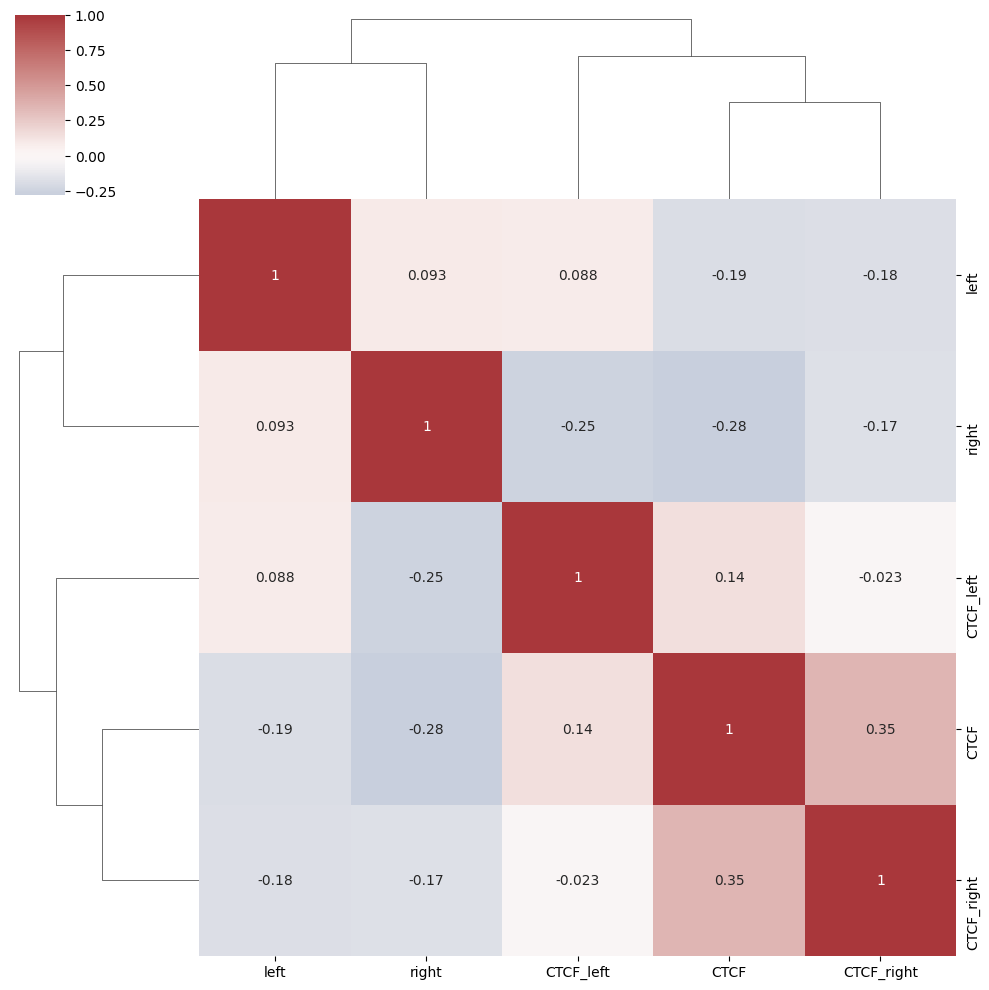

In [28]:
#tick_labels = ["CTCF", "DNAse", "CTCF_right", "CTCF_left", "left", "right"]
tick_labels = ["CTCF", "CTCF_left", "CTCF_right", "left", "right"]
params = best_loss_model.return_parameters()
seaborn.clustermap(np.corrcoef(np.vstack([tracks[[0,2,3]], np.vstack([params[0], params[1]])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

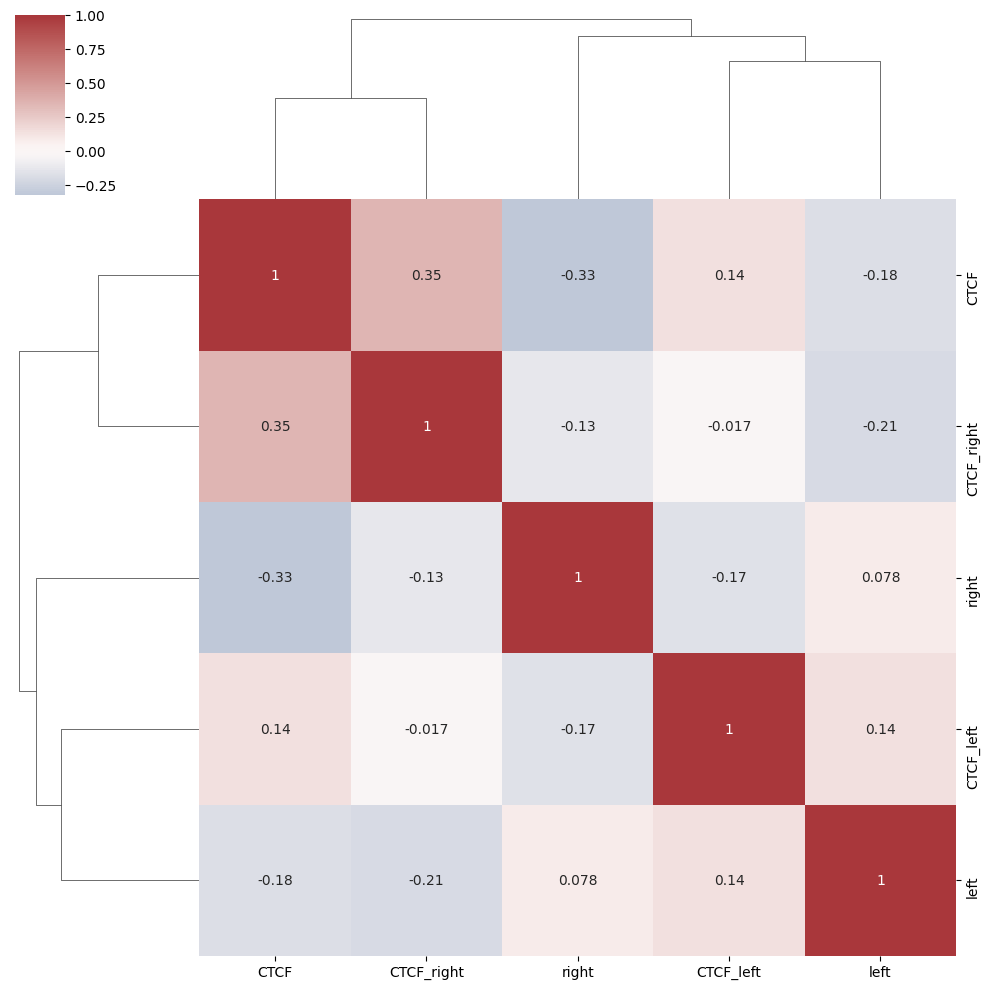

In [29]:
seaborn.clustermap(np.corrcoef(np.vstack([tracks[[0,2,3], :-1], np.vstack([params[0][1:], params[1][1:]])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

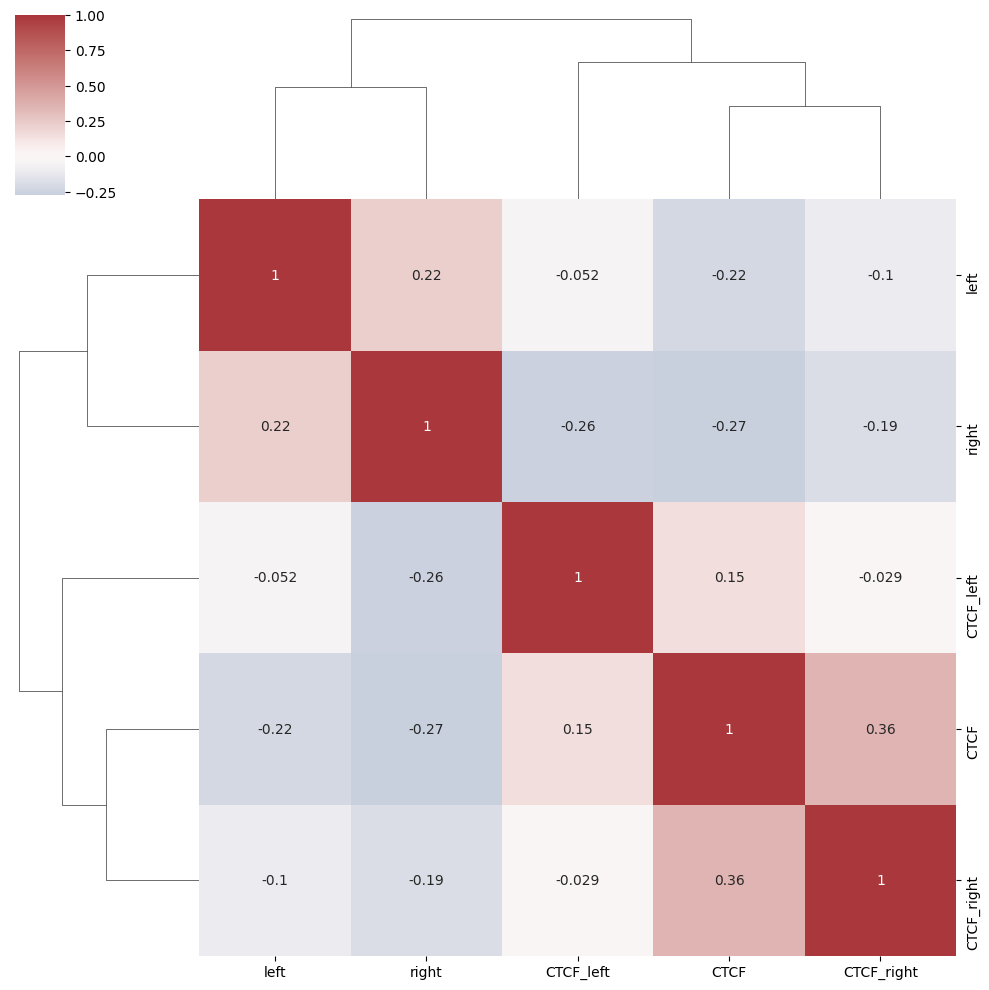

In [30]:
seaborn.clustermap(np.corrcoef(np.vstack([tracks[[0,2,3], 1:], np.vstack([params[0][:-1], params[1][1:]])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

In [31]:
params[0].var(), params[1].var()

(0.02447591, 0.02215803)

In [32]:
corrs = np.corrcoef(np.vstack([tracks[[0,2,3], :-1], np.vstack([params[0][:-1], params[1][1:]])]))

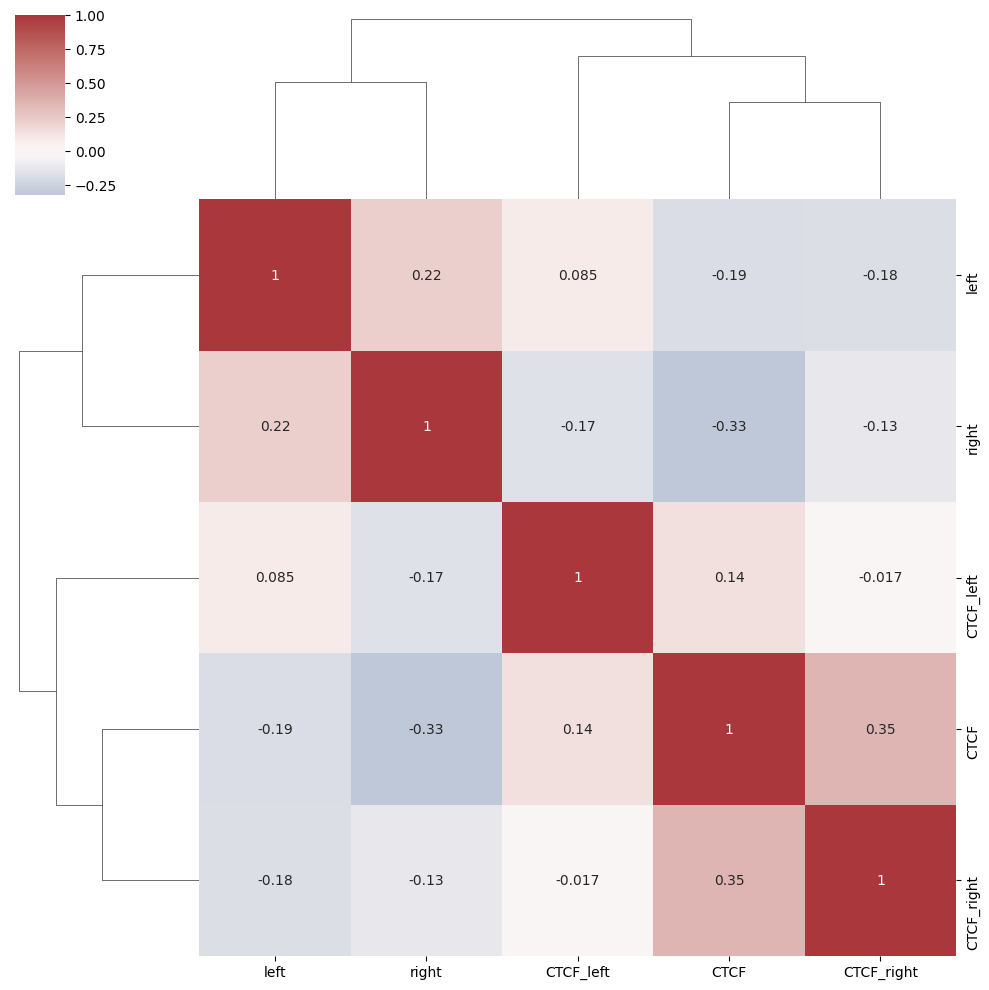

In [33]:
seaborn.clustermap(corrs,
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

In [34]:
corrs = np.corrcoef(np.vstack([tracks[[0,2,3]], np.vstack([params[0], params[1]])]))

In [35]:
tick_labels

['CTCF', 'CTCF_left', 'CTCF_right', 'left', 'right']

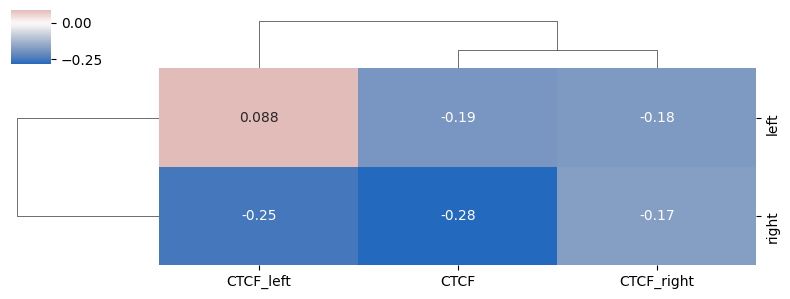

In [36]:
seaborn.clustermap(corrs[-2:, :-2],
                   yticklabels=tick_labels[-2:],
                   xticklabels=tick_labels[:-2],
                   cmap="vlag",
                   annot=True,
                   center=0,
                   figsize=(8,3))

In [37]:
tracks_cropped = tracks[[0,2,3], 5:-5]

In [38]:
param0_cropped = params[0][5:-5]
param1_cropped = params[1][5:-5]

In [39]:
corrs = np.corrcoef(np.vstack([tracks_cropped, np.vstack([param0_cropped, param1_cropped])]))

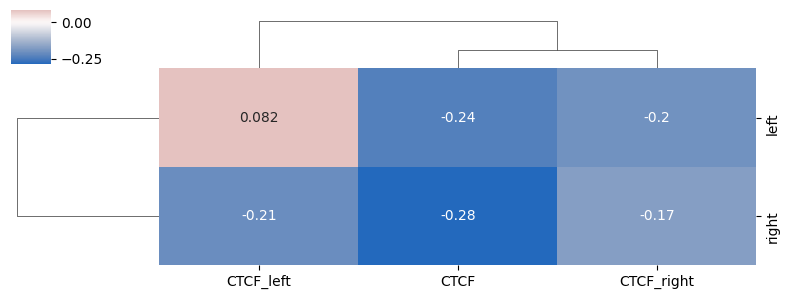

In [40]:
seaborn.clustermap(corrs[-2:, :-2],
                   yticklabels=tick_labels[-2:],
                   xticklabels=tick_labels[:-2],
                   cmap="vlag",
                   annot=True,
                   center=0,
                   figsize=(8,3))

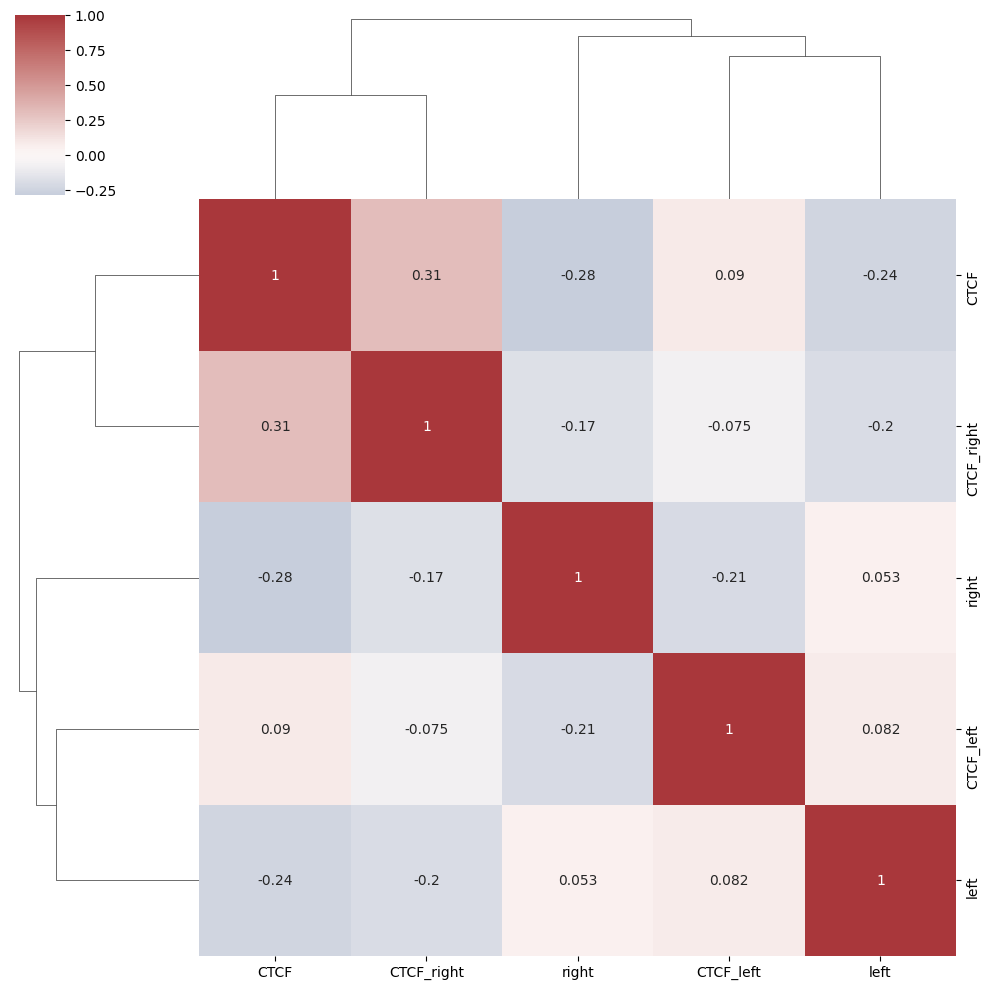

In [41]:
seaborn.clustermap(np.corrcoef(np.vstack([tracks_cropped, np.vstack([param0_cropped, param1_cropped])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

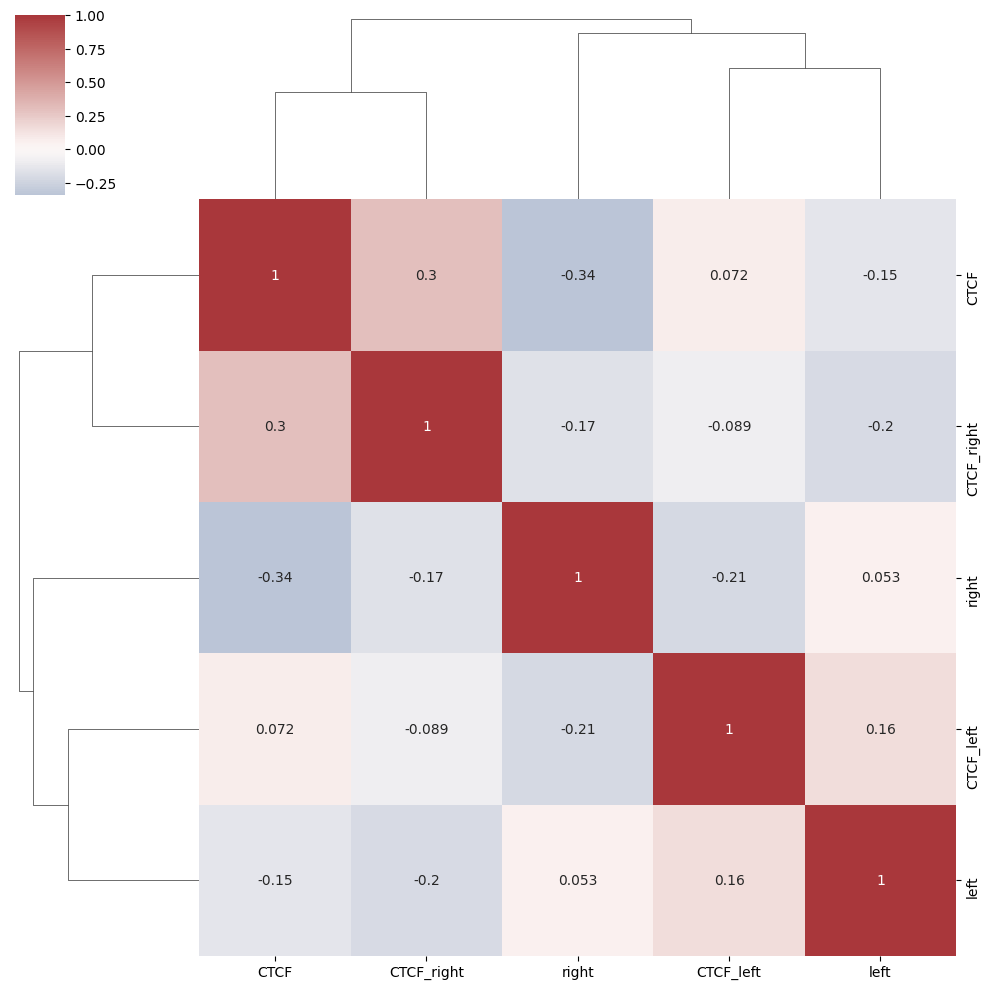

In [42]:
seaborn.clustermap(np.corrcoef(np.vstack([tracks_cropped[:, :-1], np.vstack([param0_cropped[1:], param1_cropped[1:]])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)

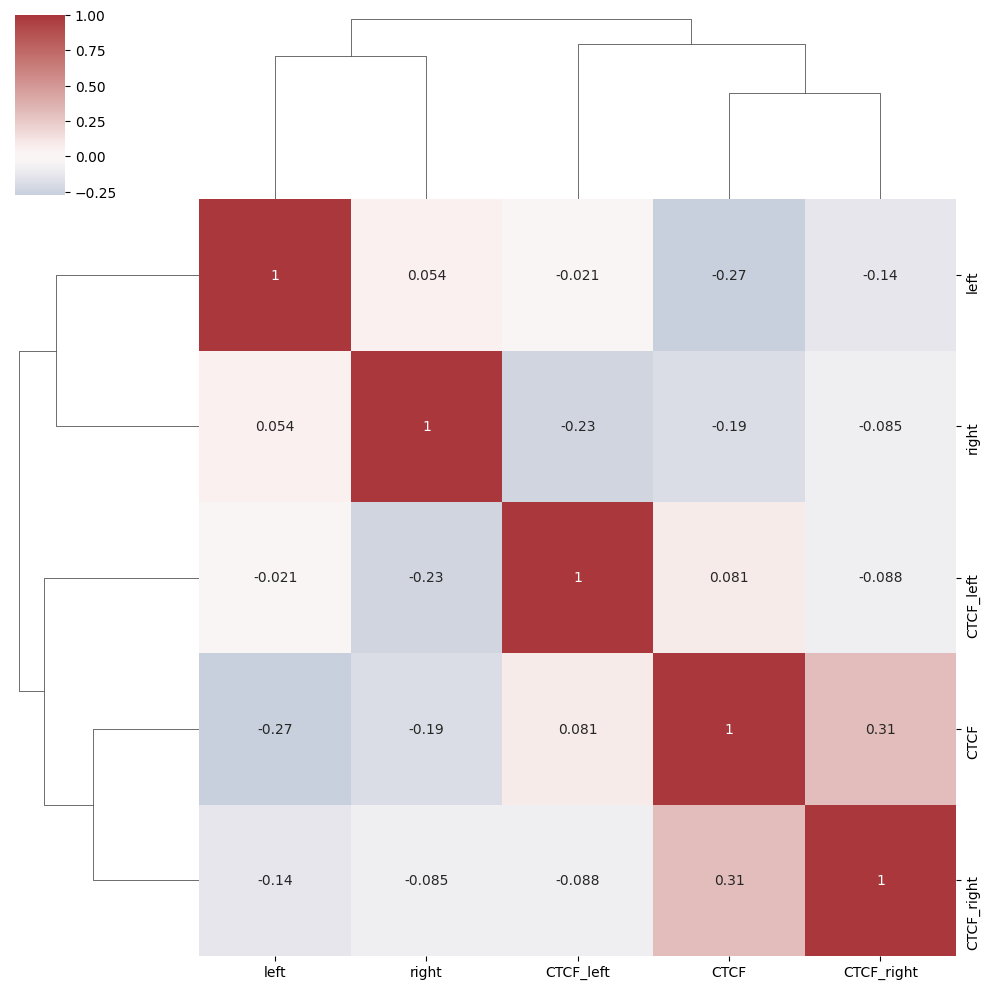

In [43]:
seaborn.clustermap(np.corrcoef(np.vstack([tracks_cropped[:, 1:], np.vstack([param0_cropped[:-1], param1_cropped[:-1]])])),
                   yticklabels=tick_labels,
                   xticklabels=tick_labels,
                   cmap="vlag",
                   center=0,
                   annot=True)